# Deep Learning Brasilia
# Lesson 2 - Week challenge!

### About the dataset

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. 
The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

The details about the full GTSRB dataset and the results of the final competition that was held at IJCNN 2011 can be found in our paper "Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition" that was accepted for publication in a Neural Networks Special Issue. 

[Link to paper](http://image.diku.dk/igel/paper/MvCBMLAfTSR.pdf)

[Link to dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

**This notebook is freely based on Udacity's Traffic Sign Classification project for the Self Driving Car Nanodegree Program, that uses the same dataset. For a reference implementation using tensorflow see: [notebook](https://github.com/lucasosouza/udacity-carnd-term1/blob/master/P2-Traffic%20Sign%20Classification/TrafficSignRecognition.ipynb)**

For the project below, the traffic signs in the original images have already been cropped, centered and resized to a standard size.

### Setting up notebook

In [1]:
# Setting AutoReload
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import csv
import pickle
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


### Loading files

In [6]:
### loading dataset. uncomment these lines to download and unzip dataset into same folder
# !wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
# !unzip traffic-signs-data.zip
# !wget https://raw.githubusercontent.com/navoshta/traffic-signs/master/signnames.csv

In [38]:
data_path = "/home/paperspace/data/traffic-signs-data/"
# data_path = "./" 

training_file = data_path + 'train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

testing_file = data_path + 'test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

labels_file = data_path + 'signnames.csv'
class_names=[]
with open(labels_file, mode='r') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for row in reader:
        class_names.append(row[1])
        
X_train, y_train = train['features'], train['labels'].astype(np.int64)
X_test, y_test = test['features'], test['labels'].astype(np.int64)
# if pytorch crashes due to errors in target, change .astype(np.int32) in both lines above to .astype(np.int64)

In [39]:
# split into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

In [40]:
# Basic data summary.

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Example class =", class_names[np.random.randint(n_classes)])

Number of training examples = 27839
Number of validation examples = 6960
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Example class = End of speed limit (80km/h)


In [41]:
X_train.shape, y_train.shape

((27839, 32, 32, 3), (27839,))

In [42]:
X_train.dtype, y_train.dtype

(dtype('uint8'), dtype('int64'))

### Visualizing dataset

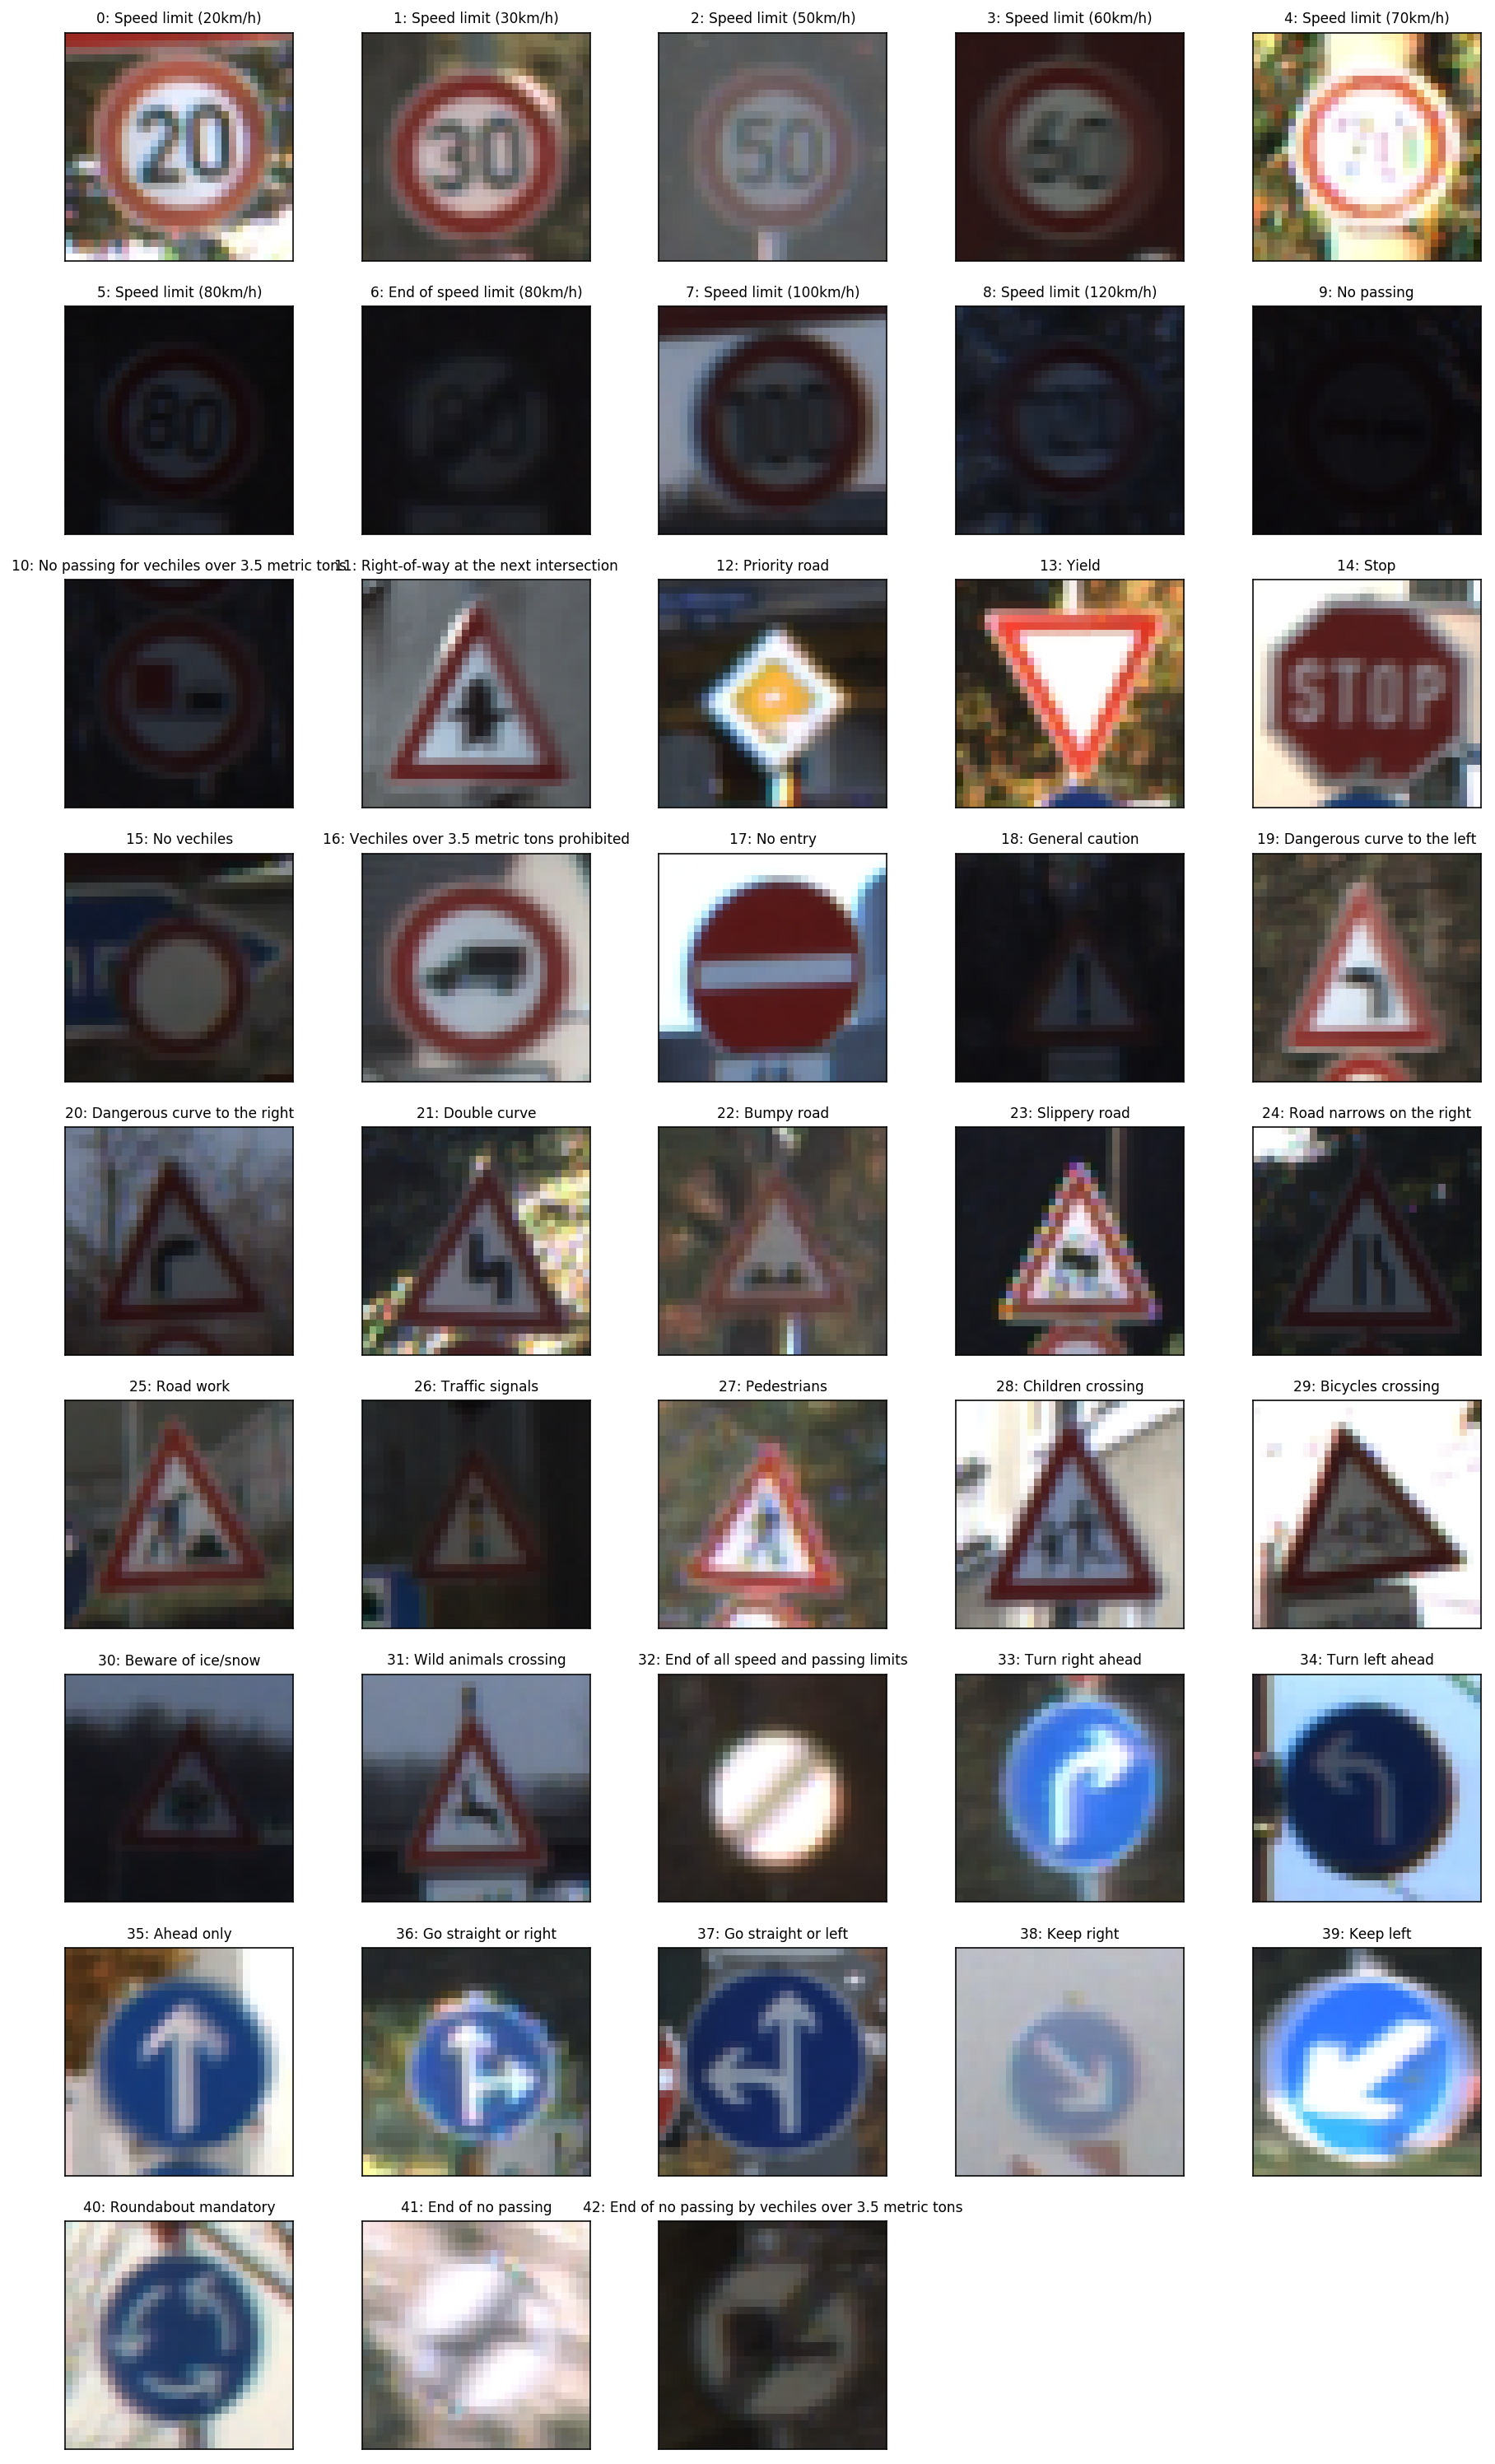

In [43]:
# show all classes
def show_all_classes(images, labels, class_names, imgs_per_row=5):

    classes = set(y_train)
    # set grid
    num_cols = int(len(classes)/imgs_per_row)+1
    plt.figure(figsize=(16, num_cols*3))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.05, hspace=0.2)

    # iterate and selet
    for klass in list(classes):
        indices = [idx for idx,y in enumerate(labels) if y==klass]
        img = images[np.random.choice(indices)]
        ax = plt.subplot(grid[klass])
        ax.imshow(img)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_title("{}: {}".format(klass, class_names[klass]), fontsize=8.5)
        
# print one image per class
show_all_classes(X_train, y_train, class_names=class_names)

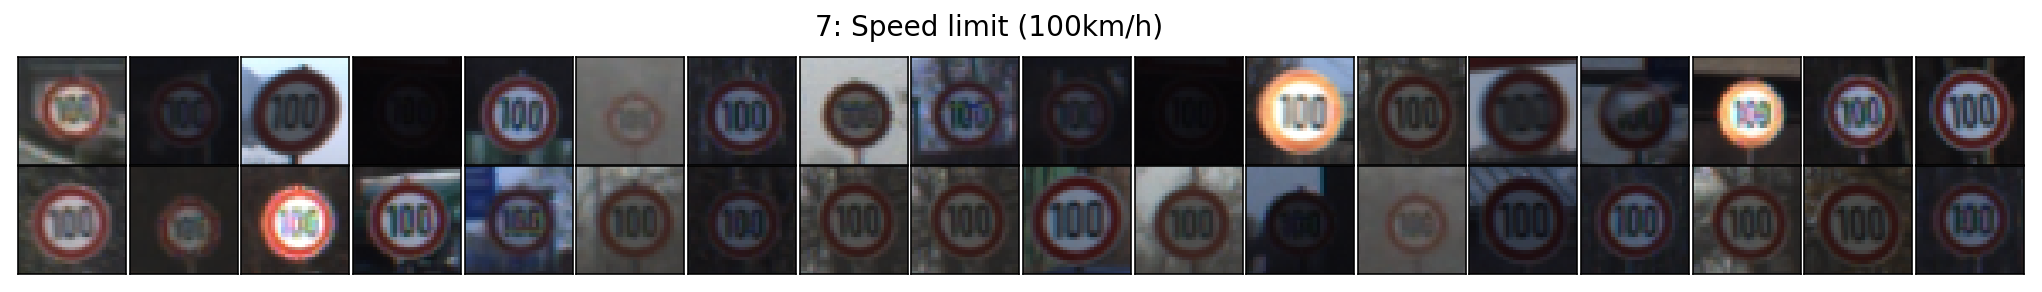

In [44]:
# show all classes
def show_samples_per_class(images, labels, class_names, selected_class, total_images=36, imgs_per_row=18):
    
    # set grid
    num_cols = int(total_images/imgs_per_row)+1
    plt.figure(figsize=(imgs_per_row, num_cols))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.01, hspace=0.01)

    # create title
    plt.gcf().suptitle("{}: {}".format(selected_class, class_names[selected_class]), fontsize=14)

    # select images
    indices = [idx for idx,y in enumerate(labels) if y==selected_class]
    selected_images = images[np.random.choice(indices, total_images)]
    
    # plot
    for idx in range(total_images):
        img = selected_images[idx]
        ax = plt.subplot(grid[idx])
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.imshow(img)
        
# print several images of a class. Change selected_class param to see images from a different class
show_samples_per_class(X_train, y_train, class_names=class_names, selected_class=7, total_images=36)

### Build classifier

In [103]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.engine import InputLayer
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [46]:
# one hot encode
num_classes = len(np.bincount(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [70]:
def conv_block(filters, kernel_size, padding='same', alpha=0.1, pooling=True, batch_norm=True):
    layers = []
    layers.append(Conv2D(filters, kernel_size, padding='same'))
    layers.append(LeakyReLU(alpha=alpha))
    if pooling: layers.append(MaxPooling2D())
    if batch_norm: layers.append(BatchNormalization())
    return np.array(layers)
 
model = Sequential([
    InputLayer(input_shape=X_train[0].shape),
    *conv_block(32,5, pooling=False), 
    *conv_block(32,3), # now 16x16
    *conv_block(64,3, pooling=False), 
    *conv_block(64,3), # now 8x8
    *conv_block(128,3, pooling=False),
    *conv_block(128,3), # now 4x4
    *conv_block(256,5, pooling=False),
    *conv_block(256,3), # now 2x2
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='sigmoid')
])

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
__________

In [72]:
# initialize Adam separately to set learning rate
opt = Adam(0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
checkpointer = ModelCheckpoint(filepath=data_path+'best_weights_keras.hdf5', verbose=0, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=32, callbacks=[checkpointer])

Train on 27839 samples, validate on 6960 samples
Epoch 1/10
27839/27839 [==============================] - 23s 821us/step - loss: 1.3769 - acc: 0.6304 - val_loss: 0.0977 - val_acc: 0.9756
Epoch 2/10
27839/27839 [==============================] - 21s 743us/step - loss: 0.0501 - acc: 0.9875 - val_loss: 0.0365 - val_acc: 0.9899
Epoch 3/10
27839/27839 [==============================] - 21s 747us/step - loss: 0.0270 - acc: 0.9930 - val_loss: 0.0540 - val_acc: 0.9849
Epoch 4/10
27839/27839 [==============================] - 21s 744us/step - loss: 0.0214 - acc: 0.9947 - val_loss: 0.0625 - val_acc: 0.9829
Epoch 5/10
27839/27839 [==============================] - 21s 744us/step - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0694 - val_acc: 0.9823
Epoch 6/10
27839/27839 [==============================] - 21s 738us/step - loss: 0.0162 - acc: 0.9957 - val_loss: 0.0353 - val_acc: 0.9901
Epoch 7/10
27839/27839 [==============================] - 21s 748us/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0

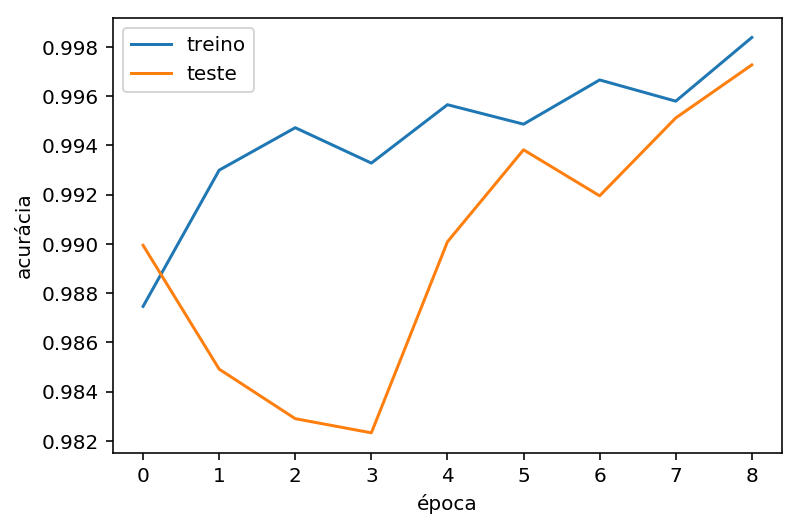

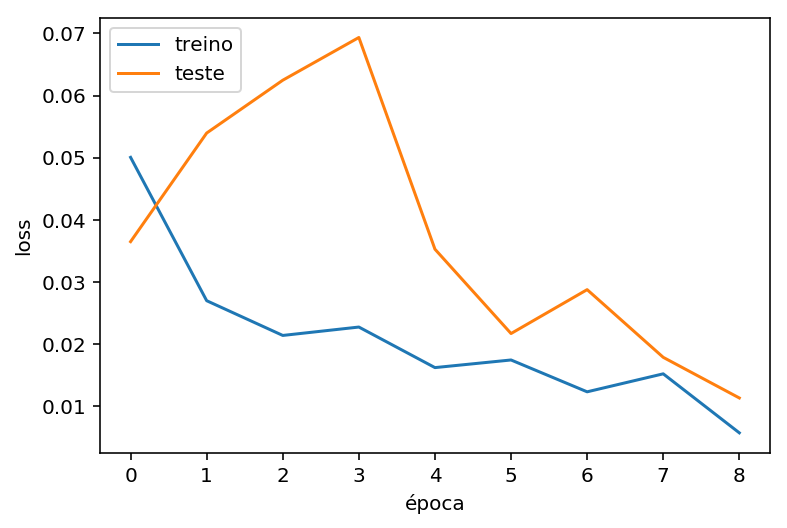

In [75]:
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.ylabel('acurácia')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('loss')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
K.set_value(model.optimizer.lr, 0.00001)plt.show()

In [98]:
checkpointer = ModelCheckpoint(filepath=data_path+'best_weights_keras.hdf5', verbose=0, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=32, callbacks=[checkpointer])

Train on 27839 samples, validate on 6960 samples
Epoch 1/10
27839/27839 [==============================] - 21s 772us/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.1569 - val_acc: 0.9602
Epoch 2/10
27839/27839 [==============================] - 22s 792us/step - loss: 0.0120 - acc: 0.9969 - val_loss: 0.0062 - val_acc: 0.9981
Epoch 3/10
27839/27839 [==============================] - 22s 796us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0275 - val_acc: 0.9948
Epoch 4/10
27839/27839 [==============================] - 24s 853us/step - loss: 0.0161 - acc: 0.9956 - val_loss: 0.0111 - val_acc: 0.9971
Epoch 5/10
27839/27839 [==============================] - 25s 895us/step - loss: 0.0081 - acc: 0.9977 - val_loss: 0.0454 - val_acc: 0.9878
Epoch 6/10
27839/27839 [==============================] - 26s 934us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0149 - val_acc: 0.9970
Epoch 7/10
27839/27839 [==============================] - 26s 916us/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0

In [106]:
# extra fine tuning round, if needed (not needed)
K.set_value(model.optimizer.lr, 1e-5)
checkpointer = ModelCheckpoint(filepath=data_path+'best_weights_keras.hdf5', verbose=0, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
         epochs=5, batch_size=32, callbacks=[checkpointer])

Train on 27839 samples, validate on 6960 samples
Epoch 1/5
27839/27839 [==============================] - 26s 920us/step - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0051 - val_acc: 0.9989
Epoch 2/5
27839/27839 [==============================] - 26s 916us/step - loss: 7.3960e-04 - acc: 0.9999 - val_loss: 0.0049 - val_acc: 0.9986
Epoch 3/5
27839/27839 [==============================] - 25s 897us/step - loss: 5.2897e-04 - acc: 0.9999 - val_loss: 0.0048 - val_acc: 0.9987
Epoch 4/5
27839/27839 [==============================] - 25s 894us/step - loss: 3.7353e-04 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 5/5
27839/27839 [==============================] - 25s 889us/step - loss: 3.3566e-04 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9986


### Validate

In [107]:
# Predict in validation set
model_preds = model.predict(X_val)
preds = np.argmax(model_preds, axis=1)
val = np.argmax(y_val, axis=1)

# Evaluate
acc = sum(preds==val)/preds.shape[0]
print("Accuracy in validation set: {:.4f}".format(acc))

Accuracy in validation set: 0.9986


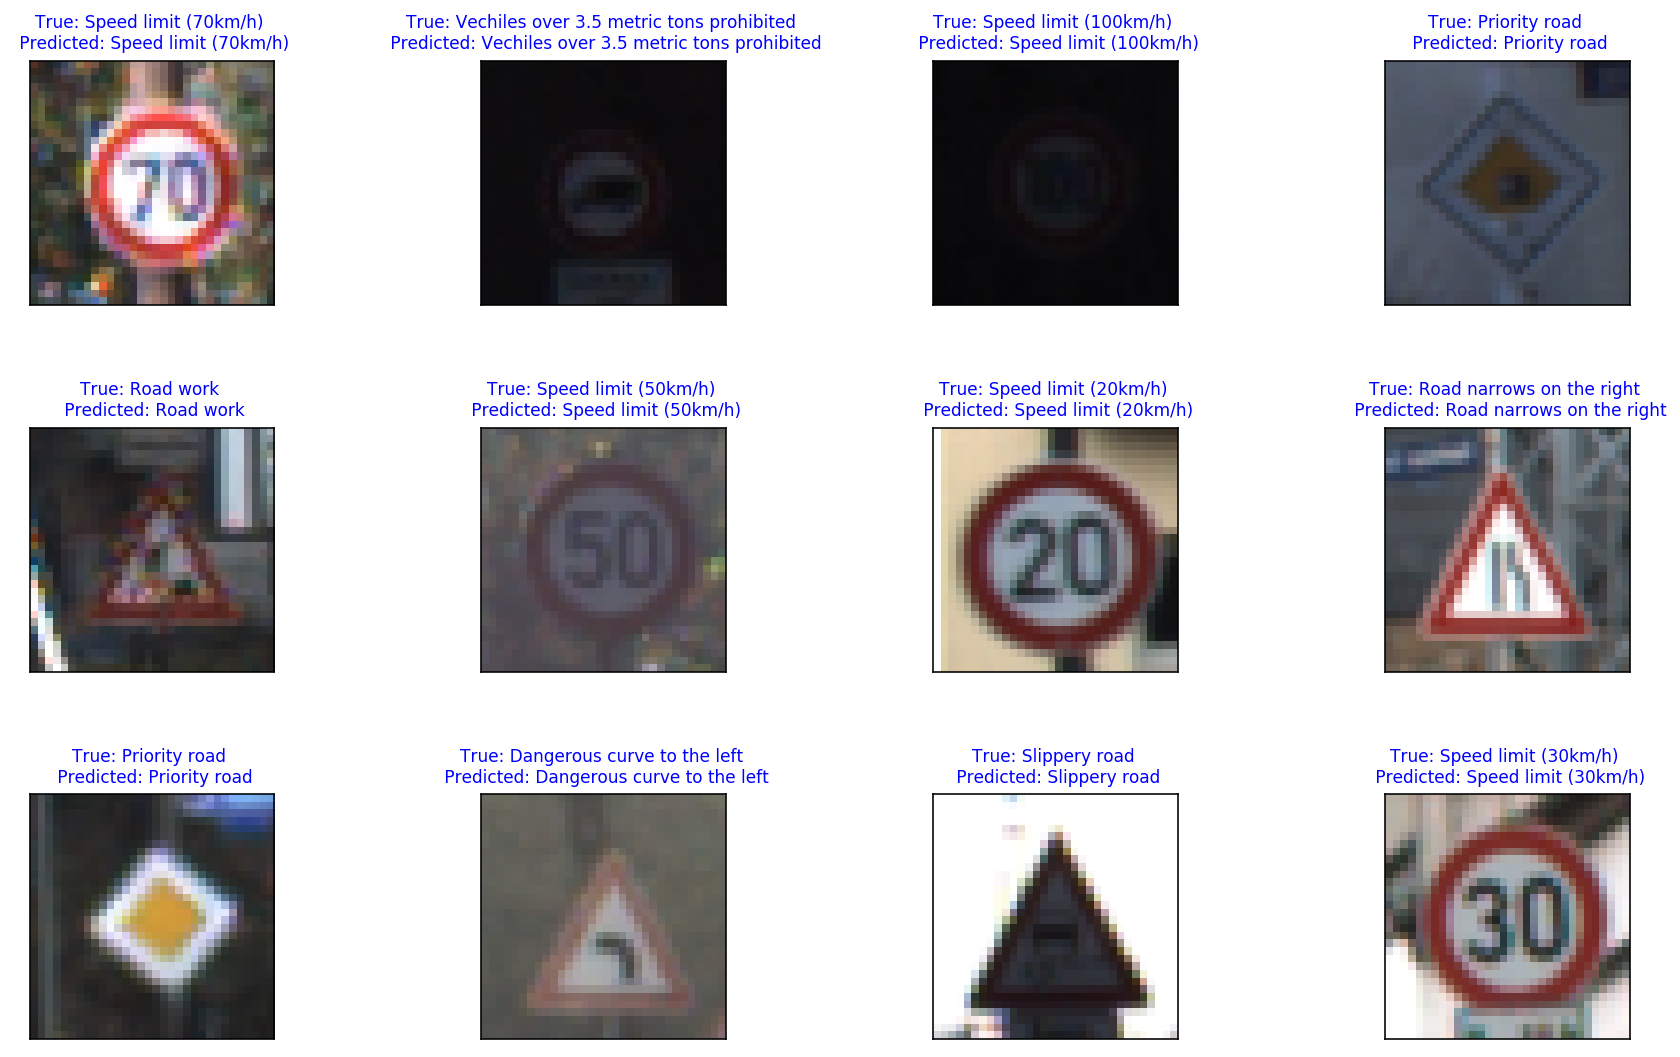

In [108]:
def show_validation_images(images, true_labels, pred_labels, imgs_per_row):
    
    num_cols = int(len(images)/imgs_per_row)
    # set grid
    plt.figure(figsize=(imgs_per_row*4, num_cols*3))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.05, hspace=0.5)

    # plot images
    for idx, (img, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
        ax = plt.subplot(grid[idx])
        ax.imshow(img)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        color = 'blue' if true_label == pred_label else 'red'
        ax.set_title("True: {} \n Predicted: {}".format(true_label, pred_label), fontsize=8.5, color=color)
        
# print random training images
indices = np.random.permutation(X_val.shape[0])[:12]
show_validation_images(X_val[indices], [class_names[n] for n in val[indices]], [class_names[n] for n in preds[indices]],
             imgs_per_row=4)

# 2. Test and report

**Important:** to avoid [data leakage](https://www.kaggle.com/wiki/Leakage), only run your final model on the test set. Use the validation set to iterate through different model versions. 

In [109]:
# load best weights
model.load_weights(data_path+'best_weights_keras.hdf5')

In [110]:
# Predict in validation set
model_preds = model.predict(X_test)
preds = np.argmax(model_preds, axis=1)
test = np.argmax(y_test, axis=1)

# Evaluate
acc = sum(preds==test)/preds.shape[0]
print("Accuracy in test set: {:.4f}".format(acc))

Accuracy in test set: 0.9778
